# NYCMesh Pano Analysis At Scale

- How many photos do nodes usually have?
- How many of these photos are panoramas, versus regular photos?

### Usage

This requires you to have this nycmesh repo cloned in the same folder as some private code

- https://github.com/nycmeshnet/node-db


## Code Setup

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import cv2

path = os.path.relpath('../python/')
sys.path.append(path)
import capture_session
import pm_generator
# import image_registration
# import geo_util

In [2]:
nycmesh_panos_dir = '../../node-db/data/panoramas/'

In [15]:
all_panos = os.listdir(nycmesh_panos_dir)
len(all_panos)

5822

In [5]:
import re

def get_photos_for_node(nn):
    photos = []
    for r, d, files in os.walk(nycmesh_panos_dir):
        for file in files:
            # photos are named with format [node number][optional alphabet character].jpg
            if re.match(str(nn) + r'[a-zA-Z]?\.+', file):
                photos.append(nycmesh_panos_dir + file)

    return photos

get_photos_for_node(231)

['../../node-db/data/panoramas/231a.jpg',
 '../../node-db/data/panoramas/231c.jpg',
 '../../node-db/data/panoramas/231b.jpg',
 '../../node-db/data/panoramas/231.jpg']

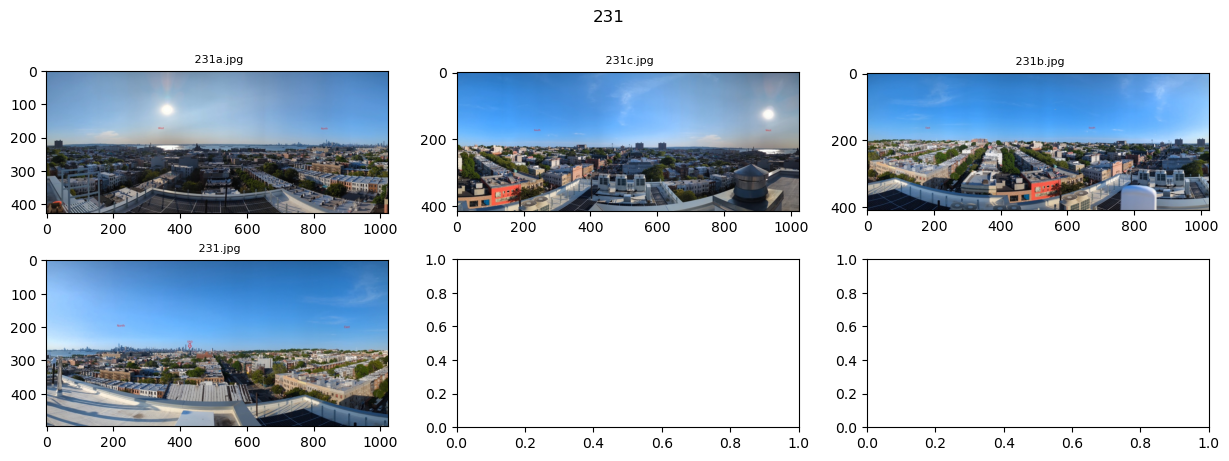

1024x426	2.403755868544601
1024x415	2.4674698795180725
1024x409	2.5036674816625917
1024x498	2.0562248995983934


['./media_ignore/231a.jpg',
 './media_ignore/231c.jpg',
 './media_ignore/231b.jpg',
 './media_ignore/231.jpg']

In [6]:
from PIL import Image

def load_nycmesh_session(nn, **kwargs):
    kwargs = { 'show_preview' : True} | kwargs
    _photos_to_compare = capture_session._downscale_cache(get_photos_for_node(nn))
    if kwargs['show_preview']:
        capture_session._session_preview(_photos_to_compare, nn)

    for i, img_path in enumerate(_photos_to_compare):
        img = Image.open(img_path)
        W, H = img.size
        print(f'{W}x{H}\t{W/H}')
    
    return _photos_to_compare

load_nycmesh_session(231, show_preview=True)

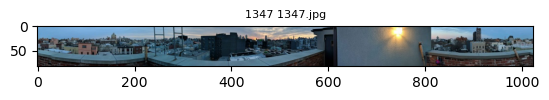

1024x83	12.337349397590362


['./media_ignore/1347.jpg']

In [7]:
load_nycmesh_session(1347)

In [8]:
# NOTE: below runs an error if session doesn't exist
# load_nycmesh_session(1)

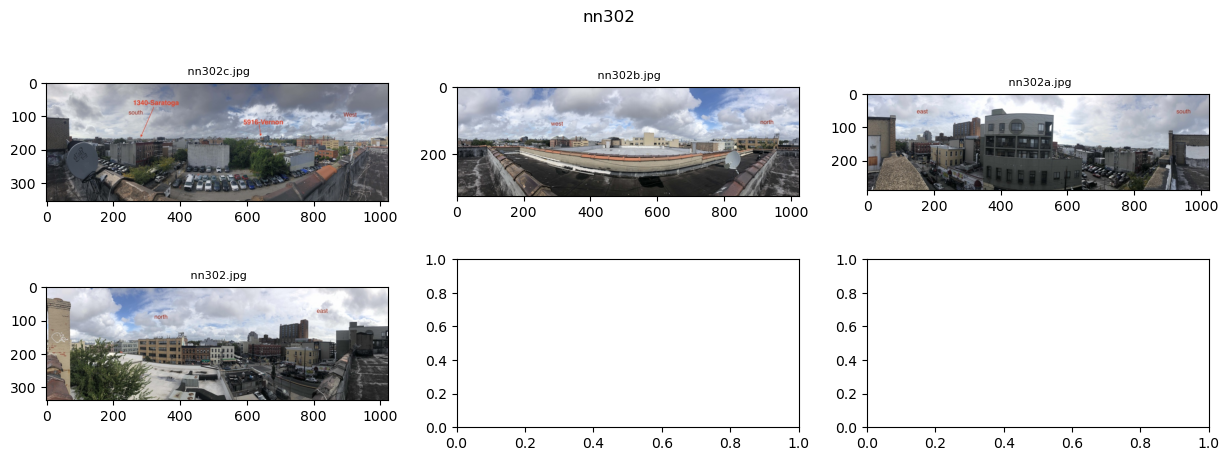

1024x354	2.8926553672316384
1024x326	3.1411042944785277
1024x288	3.5555555555555554
1024x337	3.0385756676557865


['./media_ignore/nn302c.jpg',
 './media_ignore/nn302b.jpg',
 './media_ignore/nn302a.jpg',
 './media_ignore/nn302.jpg']

In [9]:
load_nycmesh_session('nn302')

# Photo Count Per Node

In [10]:
from collections import Counter
cnts = Counter()

for r, d, files in os.walk(nycmesh_panos_dir):
    for file in files:
        # remove everything that isn't a number
        nodeNum = str(re.sub("[^0-9]", "", file))
        # check if nn or not
        if file.startswith('nn'):
            nodeNum = 'nn' + nodeNum

        # this syntax is to force Counter.update to treat the string as a whole,
        #  not individual characters
        cnts.update((nodeNum,))


Text(0.5, 0, 'Number of photos')

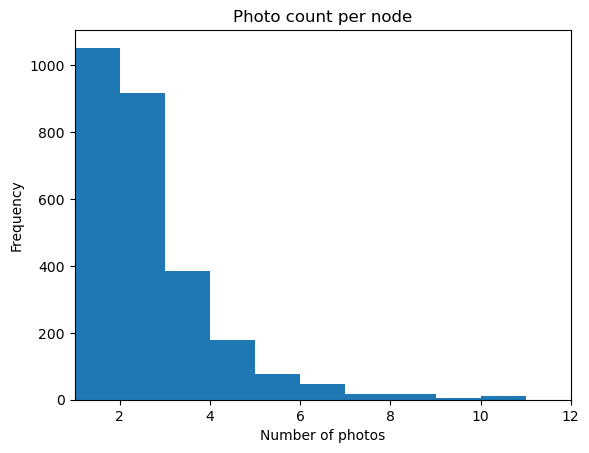

In [28]:
count_values = list(cnts.values())
n, bins, _ = plt.hist(count_values, bins = range(1, max(count_values)))
plt.xlim(1,  max(count_values))
# print(n)
# print(bins)
plt.title('Photo count per node')
plt.ylabel('Frequency')
plt.xlabel('Number of photos')

In [12]:
print(f'{n[0] / sum(n):0.2f} of nodes are only 1 photo')
for c in [3,4,5]:
    print(f'{sum(n[c-1:]) / sum(n):0.2f} of nodes are {c} or more photos')


0.39 of nodes are only 1 photo
0.27 of nodes are 3 or more photos
0.13 of nodes are 4 or more photos
0.06 of nodes are 5 or more photos


# Resolution Distribution

Hopefully we can tell the difference between regular photos, panoramas made at capture time, and stitched photos made later.

Spoiler: not clear enough

### Performance Testing

In [13]:
test_count = 200

Using OpenCV

In [16]:
rizz = np.zeros((len(all_panos), 2))

for i, img_path in enumerate(all_panos):
    filepath = nycmesh_panos_dir + img_path
    img = cv2.imread(filepath)
    H = img.shape[0]
    W = img.shape[1]

    rizz[i] = [W, H]
    
    if i == test_count:
        break

libpng warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG


In [17]:
from PIL import Image

In [18]:
rizz = np.zeros((len(all_panos), 2))

for i, img_path in enumerate(all_panos):
    filepath = nycmesh_panos_dir + img_path
    img = Image.open(filepath)
    W, H = img.size

    rizz[i] = [W, H]
    
    if i == test_count:
        break

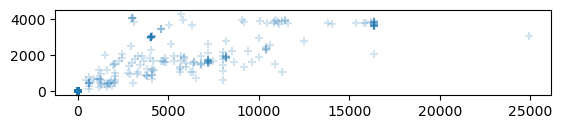

In [19]:
plt.scatter(rizz[:, 0], rizz[:, 1], alpha = 0.2, marker='+')
plt.gca().set_aspect('equal')

reading resolution of 200 photos took 80 ms with PIL, 8.6 seconds with OpenCV, 100x more. What the hell???

## Load All

In [20]:
rizz = np.zeros((len(all_panos), 2))

for i, img_path in enumerate(all_panos):
    try:
        filepath = nycmesh_panos_dir + img_path
        img = Image.open(filepath)
        W, H = img.size
        rizz[i] = [W, H]
    except Exception as e:
        print(e)

cannot identify image file '/Users/dustinfreeman/Documents/Code/node-db/data/panoramas/.DS_Store'


/Users/dustinfreeman/miniconda3/envs/hyperpan/lib/python3.12/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89619720 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/dustinfreeman/miniconda3/envs/hyperpan/lib/python3.12/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (98122752 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/dustinfreeman/miniconda3/envs/hyperpan/lib/python3.12/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (99613400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


cannot identify image file '/Users/dustinfreeman/Documents/Code/node-db/data/panoramas/12581b.jpg'


/Users/dustinfreeman/miniconda3/envs/hyperpan/lib/python3.12/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (91812864 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/dustinfreeman/miniconda3/envs/hyperpan/lib/python3.12/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89722880 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


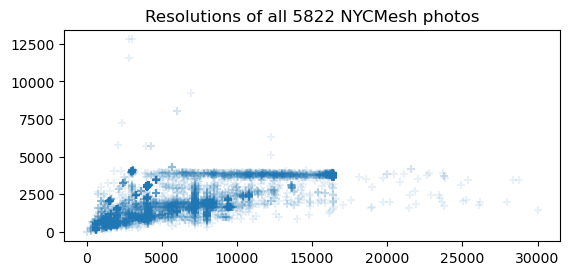

In [21]:
plt.title(f'Resolutions of all {len(all_panos)} NYCMesh photos')
plt.scatter(rizz[:, 0], rizz[:, 1], alpha = 0.1, marker='+')
plt.gca().set_aspect('equal')

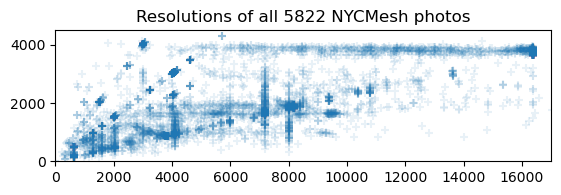

In [22]:
plt.title(f'Resolutions of all {len(all_panos)} NYCMesh photos')
plt.scatter(rizz[:, 0], rizz[:, 1], alpha = 0.1, marker='+')
plt.xlim(0, 17000)
plt.ylim(0, 4500)
plt.gca().set_aspect('equal')

In [23]:
aspect_ratios = rizz[:, 0] / rizz[:, 1]

/var/folders/ck/zkqzqzxn3710p5m8cmf3z_wc0000gn/T/ipykernel_12919/123747086.py:1: RuntimeWarning: invalid value encountered in divide
  aspect_ratios = rizz[:, 0] / rizz[:, 1]


In [25]:
sum(~np.isnan(aspect_ratios))

5820

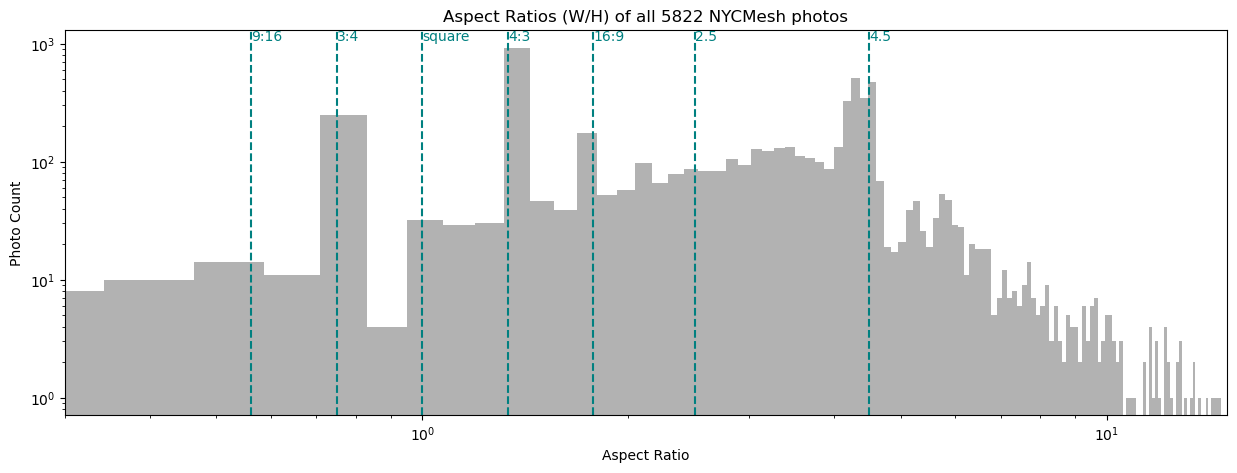

In [26]:
plt.figure(figsize = (15,5))
plt.yscale('log')
plt.xscale('log')
_ = plt.hist(aspect_ratios,bins=200, color='black', alpha=0.3)
plt.ylabel('Photo Count')
plt.xlabel('Aspect Ratio')
plt.title(f'Aspect Ratios (W/H) of all {len(all_panos)} NYCMesh photos')

plt.xlim(0.3, 15)

def label_aspect(value, label=None):
    if label is None:
        label = str(value)
    
    ymin, ymax = plt.ylim()
    ax = plt.gca()
    ax.vlines(value, color='teal', linestyle='--', ymin=ymin, ymax=ymax)
    ax.text(value, ymax, label, color='teal', ha='left', verticalalignment='top')

label_aspect(1, 'square')
label_aspect(16.0/9, '16:9')
label_aspect(4.0/3, '4:3')
label_aspect(3.0/4, '3:4')
label_aspect(9.0/16, '9:16')
label_aspect(4.5)
label_aspect(2.5)


Conclusion: no clear split between regular photos, panoramas or stitches.

## Examples with large aspect ratios

3222.jpg


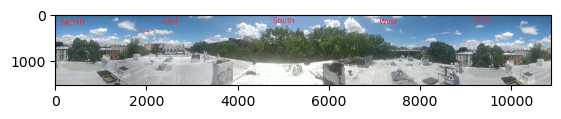

1347.jpg


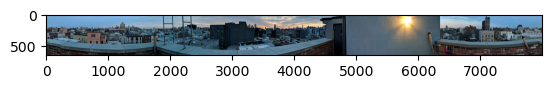

13833.jpg


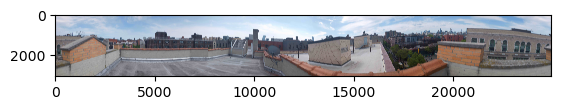

2699.jpg


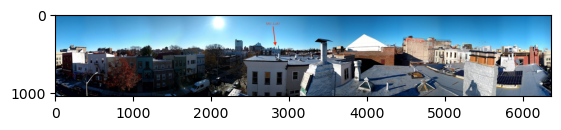

753b.jpg


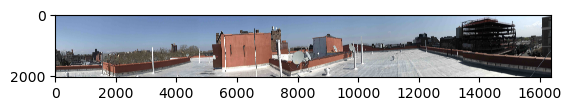

5479.jpg


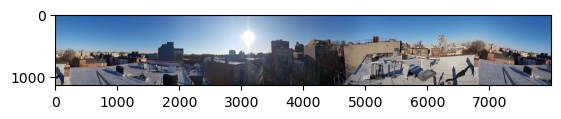

13497a.jpg


libpng warning: iCCP: known incorrect sRGB profile


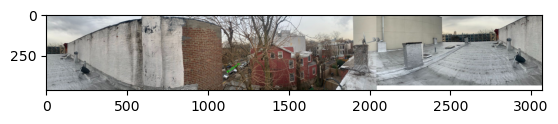

4363.jpg


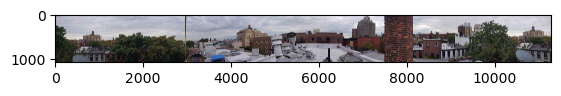

1569.jpg


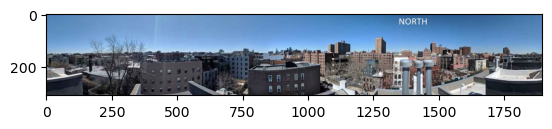

10269.jpg


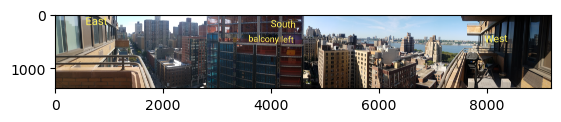

2873b.jpg


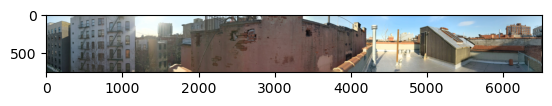

In [29]:
cnt = 0

for i, ar in enumerate(aspect_ratios):
    if ar > 6:
        cnt+= 1
        print(all_panos[i])

        # makes a notebook file that is too big:
        # display(Image.open(nycmesh_panos_dir + all_panos[i]))

        # OpenCV
        img1 = cv2.imread(nycmesh_panos_dir + all_panos[i], cv2.IMREAD_COLOR)
        # Convert from BGR to RGB (OpenCV uses BGR)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        plt.imshow(img1)
        plt.show()

    if cnt > 10:
        break